# CA2 Face Recognition                                                                        
# Name：Dong Xinyue ID：E1124282
# Question2: LDA

## Pre-processing：Self Image Processing

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

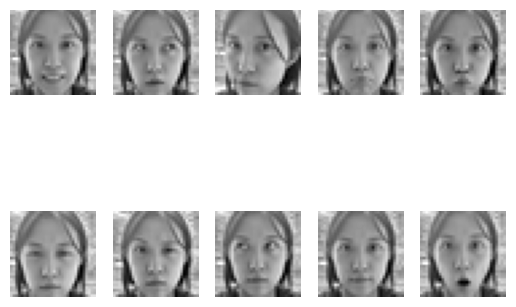

In [3]:
source_dir = os.path.join('PIE', 'my_orgimage')
target_dir = os.path.join('PIE', '69')
if not os.path.exists(target_dir):
    os.mkdir(target_dir)

image_paths = sorted([f for f in os.listdir(source_dir) if f.endswith('.jpg')])
num_rows = 2
num_columns = 5

def process_image(img_path, source_dir, target_dir):
    img = Image.open(os.path.join(source_dir, img_path)).convert('L')
    width, height = img.size
    img = img.crop((width // 8, height // 8, 7 * width // 8, 7 * height // 8)).resize((32, 32), Image.LANCZOS)
    return img

for i, img_path in enumerate(image_paths):
    img = process_image(img_path, source_dir, target_dir)
    plt.subplot(num_rows, num_columns, i % (num_rows * num_columns) + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if not os.path.exists(os.path.join(target_dir, img_path)):
        img.save(os.path.join(target_dir, img_path))
plt.show()

### Whole Dataset

In [4]:
import random
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
random.seed(77)
subjects = [69] + random.sample(range(1, 69), 25)
print('26 subject numbers:', subjects)

n_imgs_subj = [len([f for f in os.listdir(os.path.join('PIE', str(s))) if f.endswith('.jpg')]) for s in subjects]
n_imgs = sum(n_imgs_subj) 
print('number of images per subject: {}'.format(n_imgs_subj))

X = np.empty((n_imgs, 32, 32))
y = np.empty((n_imgs, 1))

for si, s in enumerate(subjects):
    for i, img_path in enumerate([f for f in os.listdir(os.path.join('PIE', str(s))) if f.endswith('.jpg')]):
        img_path = os.path.join('PIE', str(s), str(i+1)+'.jpg')
        X[sum(n_imgs_subj[:si]) + i, :, :] = np.array(Image.open(img_path))
        y[sum(n_imgs_subj[:si]) + i] = s
print('X or dataset shape: {}\ny or label shape: {}'.format(X.shape, y.shape))

# Split the data into CMUPIE and selfie subsets
X_CMUPIE = X[y.flatten() != 69]
y_CMUPIE = y[y != 69]
X_selfies = X[y.flatten() == 69]
y_selfies = y[y == 69]
X_train_CMUPIE, X_test_CMUPIE, y_train_CMUPIE, y_test_CMUPIE = train_test_split(
    X_CMUPIE, y_CMUPIE, test_size=0.3, random_state=77)
X_train_selfies, X_test_selfies, y_train_selfies, y_test_selfies = train_test_split(
    X_selfies, y_selfies, test_size=0.3, random_state=77)
X_train = np.concatenate([X_train_CMUPIE, X_train_selfies], axis=0)
y_train = np.concatenate([y_train_CMUPIE, y_train_selfies], axis=0)
X_test = np.concatenate([X_test_CMUPIE, X_test_selfies], axis=0)
y_test = np.concatenate([y_test_CMUPIE, y_test_selfies], axis=0)
print('The number of images in train set: {}\nThe number of images in in test set: {}'.format(y_train.shape[0], y_test.shape[0]))

26 subject numbers: [69, 33, 42, 26, 31, 25, 53, 61, 8, 19, 65, 36, 40, 16, 10, 58, 41, 43, 68, 1, 18, 2, 32, 12, 13, 51]
number of images per subject: [10, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170]
X or dataset shape: (4260, 32, 32)
y or label shape: (4260, 1)
The number of images in train set: 2982
The number of images in in test set: 1278


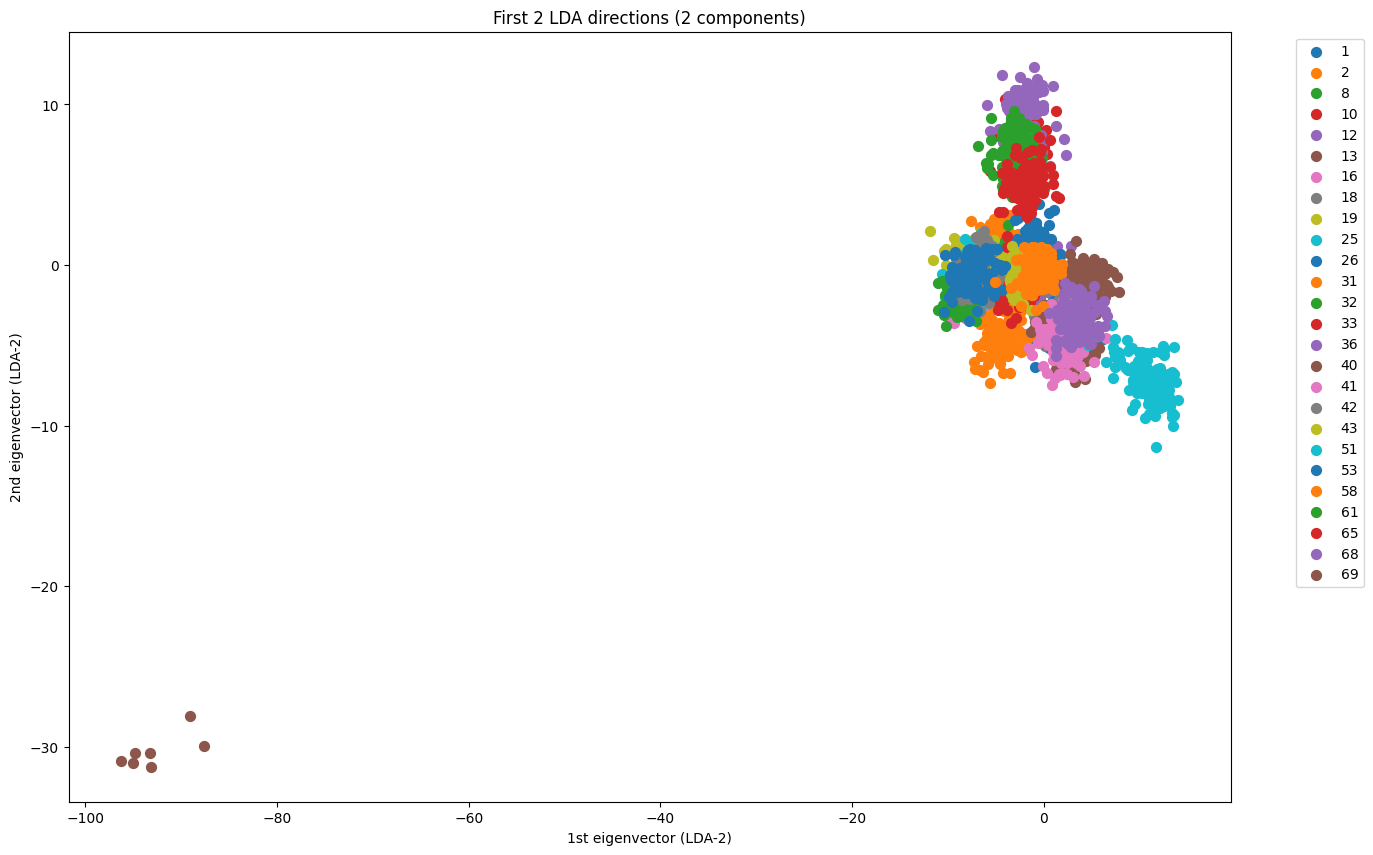

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv


class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.W = None  # Weight matrix

    def fit(self, X, y):
        class_labels = np.unique(y)
        class_means = [np.mean(X[y == label], axis=0) for label in class_labels]

        within_class_scatter = np.zeros((X.shape[1], X.shape[1]))
        between_class_scatter = np.zeros((X.shape[1], X.shape[1]))

        overall_mean = np.mean(X, axis=0)

        for label, mean in zip(class_labels, class_means):
            class_samples = X[y == label]
            centered_samples = class_samples - mean
            within_class_scatter += centered_samples.T @ centered_samples

            between_class_scatter += len(class_samples) * np.outer(mean - overall_mean, mean - overall_mean)

        # Add regularization to within-class scatter matrix
        within_class_scatter += 1e-6 * np.identity(X.shape[1])

        eigenvalues, eigenvectors = np.linalg.eig(inv(within_class_scatter) @ between_class_scatter)

        # Ensure real values
        eigenvalues = np.real(eigenvalues)
        eigenvectors = np.real(eigenvectors)

        # Sorting eigenvalues and corresponding eigenvectors in descending order
        indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[indices]
        eigenvectors = eigenvectors[:, indices]

        # Selecting the top 'n_components' eigenvectors
        selected_eigenvectors = eigenvectors[:, :self.n_components]

        self.W = selected_eigenvectors

    def transform(self, X):
        if self.W is None:
            raise ValueError("Fit the LDA model before transforming the data.")
        return X @ self.W

# Assuming X_train and y_train are your training data and labels
# Instantiate LDA with the desired number of components
n_components_lda = 2
lda = LDA(n_components_lda)

# Reshape X_train and flatten y_train if necessary
X_train_flattened = X_train.reshape(-1, 32 * 32)
y_train_flattened = y_train.flatten()

# Fit the LDA model
lda.fit(X_train_flattened, y_train_flattened)

# Transform the data
X_train_lda = lda.transform(X_train_flattened)

# Visualization in 2D
fig, ax = plt.subplots(figsize=(15, 10))

style = y_train.flatten()

for i, c in enumerate(np.unique(y_train)):
    ax.scatter(X_train_lda[:, 0][y_train.flatten() == c], X_train_lda[:, 1][y_train.flatten() == c],
                marker=None, s=50, label=int(c))

ax.set_xlabel(f'1st eigenvector (LDA-{n_components_lda})')
ax.set_ylabel(f'2nd eigenvector (LDA-{n_components_lda})')
ax.set_title(f"First 2 LDA directions ({n_components_lda} components)")
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

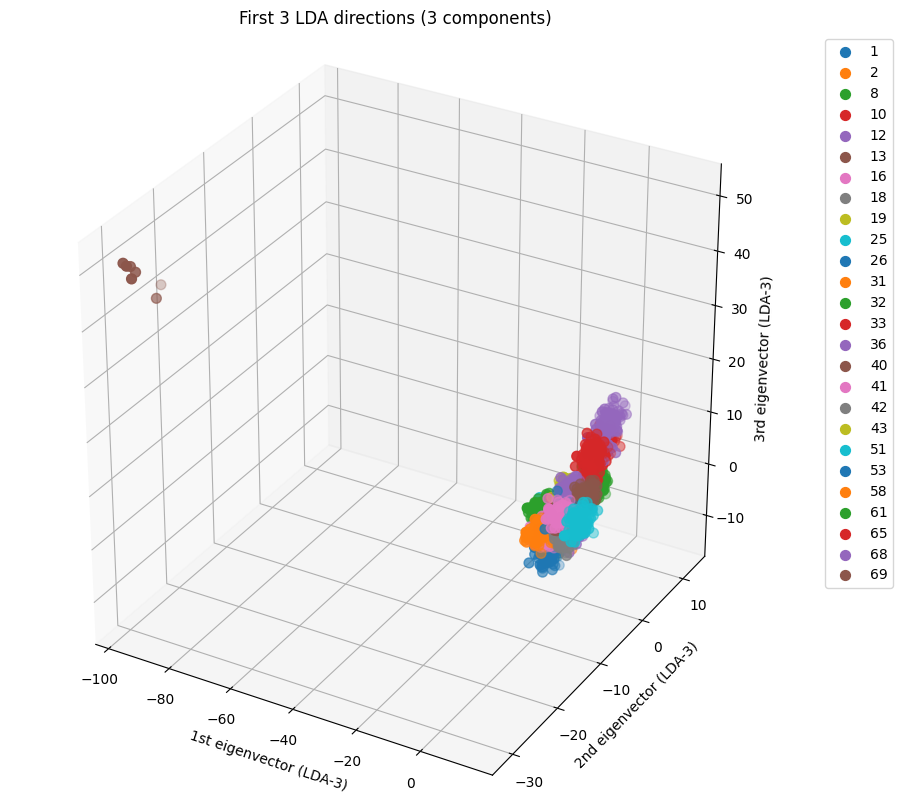

In [35]:
# Visualization in 3D
n_components_lda_3d = 3
lda_3d = LDA(n_components_lda_3d)
lda_3d.fit(X_train_flattened, y_train_flattened)
X_train_lda_3d = lda_3d.transform(X_train_flattened)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Adjust the marker size and style
marker_size = 50  # Change size if needed
marker_style = 'o'  

for i, c in enumerate(np.unique(y_train_flattened)):
    ax.scatter(X_train_lda_3d[:, 0][style == c], 
               X_train_lda_3d[:, 1][style == c], 
               X_train_lda_3d[:, 2][style == c],
               marker=marker_style, s=marker_size, label=int(c))

# Aspect ratio
ax.set_box_aspect([1,1,1])  # Equal aspect ratio

# Labels and title
ax.set_xlabel(f'1st eigenvector (LDA-{n_components_lda_3d})')
ax.set_ylabel(f'2nd eigenvector (LDA-{n_components_lda_3d})')
ax.set_zlabel(f'3rd eigenvector (LDA-{n_components_lda_3d})')
ax.set_title(f"First 3 LDA directions ({n_components_lda_3d} components)")

# Legend
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()

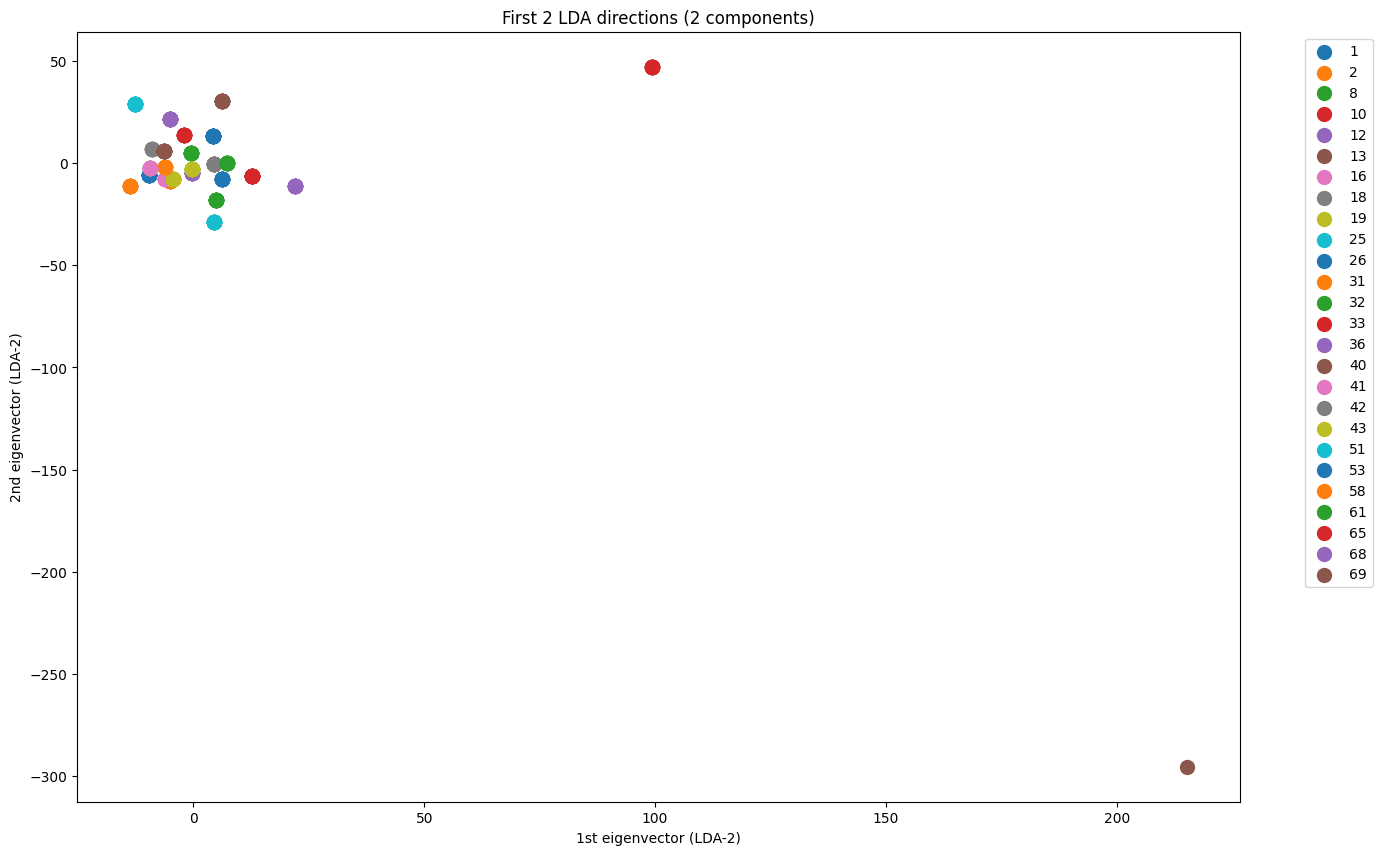

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

random.seed(77)
selected_image_indices = np.sort(random.sample(range(X_train.shape[0]), 500))
X_selected = X_train[selected_image_indices, :, :]
y_selected = y_train[selected_image_indices]
class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.W = None  # Weight matrix

    def fit(self, X, y):
        class_labels = np.unique(y)
        class_means = [np.mean(X[y == label], axis=0) for label in class_labels]

        within_class_scatter = np.zeros((X.shape[1], X.shape[1]))
        between_class_scatter = np.zeros((X.shape[1], X.shape[1]))

        overall_mean = np.mean(X, axis=0)

        for label, mean in zip(class_labels, class_means):
            class_samples = X[y == label]
            centered_samples = class_samples - mean
            within_class_scatter += centered_samples.T @ centered_samples

            between_class_scatter += len(class_samples) * np.outer(mean - overall_mean, mean - overall_mean)

        # Add regularization to within-class scatter matrix
        within_class_scatter += 1e-6 * np.identity(X.shape[1])

        eigenvalues, eigenvectors = np.linalg.eig(inv(within_class_scatter) @ between_class_scatter)

        # Ensure real values
        eigenvalues = np.real(eigenvalues)
        eigenvectors = np.real(eigenvectors)

        # Sorting eigenvalues and corresponding eigenvectors in descending order
        indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[indices]
        eigenvectors = eigenvectors[:, indices]

        # Selecting the top 'n_components' eigenvectors
        selected_eigenvectors = eigenvectors[:, :self.n_components]

        self.W = selected_eigenvectors

    def transform(self, X):
        if self.W is None:
            raise ValueError("Fit the LDA model before transforming the data.")
        return X @ self.W

# Assuming X_train and y_train are your training data and labels
# Instantiate LDA with the desired number of components
n_components_lda = 2
lda = LDA(n_components_lda)

# Reshape X_train and flatten y_train if necessary
X_train_flattened =X_selected.reshape(-1, 32 * 32)
y_train_flattened = y_selected.flatten()

# Fit the LDA model
lda.fit(X_train_flattened, y_train_flattened)

# Transform the data
X_train_lda = lda.transform(X_train_flattened)

# Visualization in 2D
fig, ax = plt.subplots(figsize=(15, 10))

style =  y_selected.flatten()

for i, c in enumerate(np.unique( y_selected)):
    ax.scatter(X_train_lda[:, 0][ y_selected.flatten() == c], X_train_lda[:, 1][ y_selected.flatten() == c],
                marker=None, s=100, label=int(c))

ax.set_xlabel(f'1st eigenvector (LDA-{n_components_lda})')
ax.set_ylabel(f'2nd eigenvector (LDA-{n_components_lda})')
ax.set_title(f"First 2 LDA directions ({n_components_lda} components)")
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

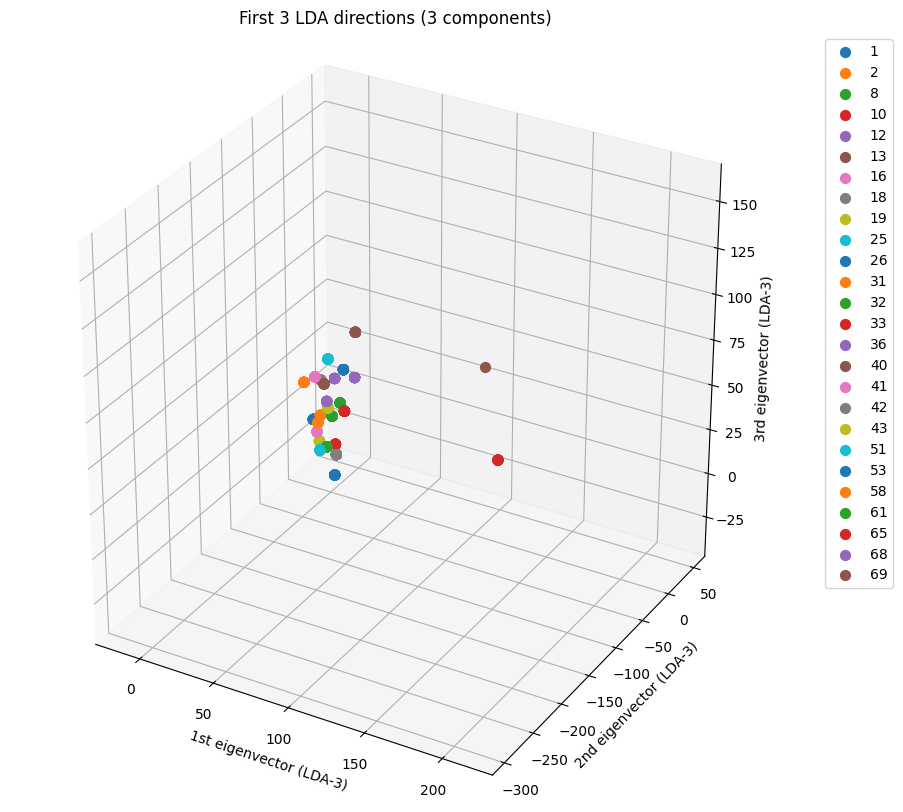

In [41]:
# Visualization in 3D
n_components_lda_3d = 3
lda_3d = LDA(n_components_lda_3d)
lda_3d.fit(X_train_flattened, y_train_flattened)
X_train_lda_3d = lda_3d.transform(X_train_flattened)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Adjust the marker size and style
marker_size = 50  # Change size if needed
marker_style = 'o'  

for i, c in enumerate(np.unique(y_train_flattened)):
    ax.scatter(X_train_lda_3d[:, 0][style == c], 
               X_train_lda_3d[:, 1][style == c], 
               X_train_lda_3d[:, 2][style == c],
               marker=marker_style, s=marker_size, label=int(c))

# Aspect ratio
ax.set_box_aspect([1,1,1])  # Equal aspect ratio

# Labels and title
ax.set_xlabel(f'1st eigenvector (LDA-{n_components_lda_3d})')
ax.set_ylabel(f'2nd eigenvector (LDA-{n_components_lda_3d})')
ax.set_zlabel(f'3rd eigenvector (LDA-{n_components_lda_3d})')
ax.set_title(f"First 3 LDA directions ({n_components_lda_3d} components)")

# Legend
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()

In [28]:
import scipy.spatial
from collections import Counter
from sklearn.metrics import accuracy_score
# Apply LDA and nearest neighbor classification
class KNN:
    def __init__(self, k):
        self.k = k    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y 
    def predict(self, X_test):
        final_output = []
        for i in range(len(X_test)):
            distances = []
            votes = []
            for j in range(len(self.X_train)):
                dist = scipy.spatial.distance.euclidean(self.X_train[j], X_test[i])
                distances.append((dist, j))
            distances.sort()
            neighbors = distances[:self.k]
            for dist, idx in neighbors:
                votes.append(self.y_train[idx])
            ans = Counter(votes).most_common(1)[0][0]
            final_output.append(ans)
        return final_output
    def score(self, X_test, y_test):
        predictions = self.predict(X_test)
        return (predictions == y_test).sum() / len(y_test)

# Apply LDA and nearest neighbor classification
def apply_lda_knn(X_train, y_train, X_test_CMUPIE, y_test_CMUPIE, X_test_selfies, y_test_selfies, n_components_list=[2, 3, 9], neighbors=3):
    results = {}

    for n_components in n_components_list:
        print(f"\nNumber of LDA Components: {n_components}")

        # Apply LDA
        lda_model = LDA(n_components=n_components)
        lda_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
        X_train_LDA = lda_model.transform(X_train.reshape(X_train.shape[0], -1))

        # Transform test sets
        X_test_CMUPIE_LDA = lda_model.transform(X_test_CMUPIE.reshape(X_test_CMUPIE.shape[0], -1))
        X_test_selfies_LDA = lda_model.transform(X_test_selfies.reshape(X_test_selfies.shape[0], -1))

        # Train KNN classifier
        knn_model = KNN(k=neighbors)
        knn_model.fit(X_train_LDA, y_train)

        # Make predictions
        y_pred_CMUPIE = knn_model.predict(X_test_CMUPIE_LDA)
        y_pred_selfies = knn_model.predict(X_test_selfies_LDA)

        # Calculate accuracy scores
        acc_CMUPIE = accuracy_score(y_test_CMUPIE, y_pred_CMUPIE)
        acc_selfies = accuracy_score(y_test_selfies, y_pred_selfies)

        results[n_components] = {'CMUPIE': acc_CMUPIE, 'selfies': acc_selfies}
        print(f"Accuracy on CMUPIE: {acc_CMUPIE}")
        print(f"Accuracy on selfies: {acc_selfies}")
    return results

# Apply LDA and KNN classification
results_lda_knn = apply_lda_knn(X_train, y_train, X_test_CMUPIE, y_test_CMUPIE, X_test_selfies, y_test_selfies)


Number of LDA Components: 2
Accuracy on CMUPIE: 0.31137254901960787
Accuracy on selfies: 0.6666666666666666

Number of LDA Components: 3
Accuracy on CMUPIE: 0.5090196078431373
Accuracy on selfies: 0.6666666666666666

Number of LDA Components: 9
Accuracy on CMUPIE: 0.9207843137254902
Accuracy on selfies: 0.6666666666666666
